In [1]:
# Import used packages
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import random

# Network implementation

In [2]:
# Create positions in rectangle of xlen x ylen
def randompos(nodes, pictureWidth, pictureHeight):
    pos = []
    for i in range(nodes):
        pos.append([pictureWidth*random.uniform(0, 1), pictureHeight*random.uniform(0, 1)])
    return pos

# Link nodes
def linknodes(pos, radius):
    links = []
    sets = []
    for i in range(len(pos)):
        linksCurrent = []
        for j in range(len(pos)):
            distance = (pos[i][0] - pos[j][0])**2 + (pos[i][1] - pos[j][1])**2
            if distance <= radius**2:
                if i != j:
                    linksCurrent.append(j)
                    if {i, j} not in sets:
                        sets.append({i, j})
        links.append(linksCurrent)
    return links, sets

# Create network in a dictionary structure
def createnetwork(nodes, radius, pictureWidth, pictureHeight):
    Network = {'nodes': nodes, 'pos': randompos(nodes, pictureWidth, pictureHeight)}
    Network['links'], Network['sets'] = linknodes(Network['pos'], radius)
    return Network

# plot nodes
def plotnodes(pos, ax, sizeNodes, colorNodes):
    ax.scatter([item[0] for item in pos], [item[1] for item in pos], s= sizeNodes, c= colorNodes, zorder= 2)
    
def plotedges(pos, ax, sets, colorEdges, alphaEdges):
    xList = []
    yList = []
    for linkedNodes in sets:
        for element in linkedNodes:
            xList += [pos[element][0]]
            yList += [pos[element][1]]
        xList += [np.nan]
        yList += [np.nan]
    ax.plot(xList, yList, color = colorEdges, alpha= alphaEdges, zorder= 1)

# Implementation of SEIR model
## Model
The SEIR model describes the propagation of a disease in 4 stages: susceptible, exposed, infected and recovered. Each state has different properties. At the start most people are susceptible, these can get exposed when in contact with someone who is infected. Exposed people cannot infect other people yet. They will get infectious after some time, dependent on the incubation period. Infected people can recover, when recovered they are immune to the dissease.
## Parameters
We used $\beta$ as the probability to become exposed when in contact with 1 infected person, $\delta$ is the probability of becoming infected when exposed and $\gamma$ is the probability to recover when infected.
## Datastructure
To contain all the data, we used a dictionairy 'Network'. This contains the following keys: <br>
- 'nodes': int, the amount of nodes <br>
- 'pos': list of length 'nodes', list of lists of length 2 containing the x and y positions of the nodes <br>
- 'links': list of length 'nodes', list of lists containing the numbers corresponding to the nodes connected to the i'th node <br>
- 'sets': list, list of sets containing all connected nodes <br>
- 'currentState': list, list of the stage of the i'th node at the current timestep <br>
- 'currentColor': list, list of the color of the i'th node at the current timestep <br>
- 'newState': list, list of the stage of the i'th node at the next timestep <br>
- 'dataStates': list (of lists), list of all the lists passing 'currentState' <br>
- 'dataColors': list (of lists), list of all the lists passing 'currentColor' <br>
- 'time': list, list of consecutive integers representing the timesteps <br>
- 'S': list, list of how many nodes are in the susceptible stage at the i'th timestep <br>
- 'E': list, list of how many nodes are in the exposed stage at the i'th timestep <br>
- 'I': list, list of how many nodes are in the infected stage at the i'th timestep <br>
- 'R': list, list of how many nodes are in the recovered stage at the i'th timestep <br>

In [3]:
# Declare global parameters
class ST_base():
    pass

ST = ST_base()
ST.S = 0
ST.E = 1
ST.I = 2
ST.R = 3

class ST_color():
    pass

STcolor = ST_color()
STcolor.S = 'palegreen'
STcolor.E = 'orchid'
STcolor.I = 'tomato'
STcolor.R = 'deepskyblue'

class PL_attributes():
    pass

PL = PL_attributes()
PL.edgeColor = 'grey'
PL.edgeAlpha = 0.4
PL.nodeSize = 80

In [4]:
def start(nodes, radius, exposedPerc, pictureWidth, pictureHeight):
    Network = createnetwork(nodes, radius, pictureWidth, pictureHeight)
    Network['currentState'] = [ST.S]*nodes
    Network['currentColor'] = [STcolor.S]*nodes
    exposed = startperc(Network, exposedPerc)
    for i in exposed:
        Network['currentState'][i] = ST.E
        Network['currentColor'][i] = STcolor.E
        
    return Network

def startperc(Network, exposedPerc):
    exposed = [random.randint(0, Network['nodes'] - 1)]
    while len(exposed) < Network['nodes']*exposedPerc:
        exposedNew = exposed.copy()
        for i in exposedNew:
            for j in range(len(Network['links'][i])):
                if len(exposedNew) < Network['nodes']*exposedPerc:
                    if Network['links'][i][j] not in exposedNew:
                        exposedNew.append(Network['links'][i][j])
                else:
                    return exposedNew
        if len(exposed) == len(exposedNew):
            return startperc(Network, exposedPerc)
        exposed = exposedNew
    
    return exposed

In [5]:
# Create list of the next state after 1 timestep
def updateSEIR(Network, beta, delta, gamma):
    Network['newState'] = []
    for i in range(Network['nodes']):
        if Network['currentState'][i] == ST.S:
            Phealthy = 1
            for j in Network['links'][i]:
                if Network['currentState'][j] == ST.I:
                    Phealthy *= (1 - beta)
            PSick = 1 - Phealthy
            randomN = random.uniform(0, 1)
            if randomN < PSick:
                Network['newState'].append(ST.E)
                Network['currentColor'][i] = STcolor.E
            else:
                Network['newState'].append(Network['currentState'][i])
        elif Network['currentState'][i] == ST.E:
            randomN = random.uniform(0, 1)
            if randomN < delta:
                Network['newState'].append(ST.I)
                Network['currentColor'][i] = STcolor.I
            else:
                Network['newState'].append(Network['currentState'][i])
        elif Network['currentState'][i] == ST.I:
            randomN = random.uniform(0, 1)
            if randomN < gamma:
                Network['newState'].append(ST.R)
                Network['currentColor'][i] = STcolor.R
            else:
                Network['newState'].append(Network['currentState'][i])
        else:
            Network['newState'].append(Network['currentState'][i])
    Network['currentState'] = Network['newState']
    
    return Network

# Creates list holding all information of the situation in every time step 
# and plots color-coded network of every timestep if plotNetwork is True
def spreaddiseaseSEIR(Network, NTimeSteps, beta, delta, gamma, pictureWidth, pictureHeight, plotNetworks, socialDistance):
    Network['dataStates'] = [Network['currentState']]
    Network['dataColors'] = [Network['currentColor'].copy()]
    
    if plotNetworks:
        for i in range(NTimeSteps):
            Network = updateSEIR(Network, beta, delta, gamma)
            Network['dataStates'].append(Network['currentState'])
            Network['dataColors'].append(Network['currentColor'].copy())
        
            fig, ax = plt.subplots(figsize = [6*pictureWidth, 6*pictureHeight])
            plotedges(Network['pos'], ax, Network['sets'], PL.edgeColor, PL.edgeAlpha)
            plotnodes(Network['pos'], ax, PL.nodeSize, Network['currentColor'])
            plt.axis('off')
            plt.show()
            
    else:
        for i in range(NTimeSteps):
            Network = updateSEIR(Network, beta, delta, gamma)
            Network['dataStates'].append(Network['currentState'])
            Network['dataColors'].append(Network['currentColor'].copy())
                
    return Network

# Count the amount of people in each state for every timestep
def countingSEIR(Network):
    Network['S'] = []
    Network['E'] = []
    Network['I'] = []
    Network['R'] = []
    for i in range(len(Network['dataStates'])):
        counting = np.bincount(Network['dataStates'][i], minlength = 4)
        Network['S'].append(counting[ST.S])
        Network['E'].append(counting[ST.E])
        Network['I'].append(counting[ST.I])
        Network['R'].append(counting[ST.R])
        
    return Network

# Executes all the functions above 
# and plots the evolution in all states with respect to time if plotStates is True
def everythingSEIR(Network, NTimeSteps, beta, delta, gamma, pictureWidth, pictureHeight, plotNetworks, plotStates, socialDistance):
    
    if plotNetworks:
        fig, ax = plt.subplots(figsize = [6*xlen, 6*ylen])
        plotedges(Network['pos'], ax, Network['sets'], PL.edgeColor, PL.edgeAlpha)
        plotnodes(Network['pos'], ax, PL.nodeSize, Network['currentColor'])
        plt.axis('off')
        plt.show()
    
    Network = spreaddiseaseSEIR(Network, NTimeSteps, beta, delta, gamma, pictureWidth, pictureHeight, plotNetworks, socialDistance)
    
    Network = countingSEIR(Network)
    Network['time'] = np.arange(0, NTimeSteps + 1, 1)
    if plotStates:
        figData = plt.figure()

        plt.plot(Network['time'], Network['S'], label = 'S', color= STcolor.S)
        plt.plot(Network['time'], Network['E'], label = 'E', color= STcolor.E)
        plt.plot(Network['time'], Network['I'], label = 'I', color= STcolor.I)
        plt.plot(Network['time'], Network['R'], label = 'R', color= STcolor.R)

        plt.title('', size= 20)
        plt.ylabel('', size= 20)
        plt.xlabel('', size= 20)
        plt.legend(fontsize= 12)
        plt.ylim(0, nodes)
        plt.xlim(0, NTimesteps)
        plt.tick_params(axis= 'both', which= 'major', labelsize= 14)
        plt.grid()

        plt.show()
    return Network

# Averages over N different networks and evolutions of disseasespreading
def averageSEIR(nodes, exposedPerc, radius, NTimeSteps, beta, delta, gamma, pictureWidth, pictureHeight, N, plotAverage):
    averageS = np.zeros(NTimeSteps + 1)
    averageE = np.zeros(NTimeSteps + 1)
    averageI = np.zeros(NTimeSteps + 1)
    averageR = np.zeros(NTimeSteps + 1)
    for i in range(N):
        Network = start(nodes, radius, exposedPerc, pictureWidth, pictureHeight)
        Network = everythingSEIR(Network, NTimeSteps, beta, delta, gamma, pictureWidth, pictureHeight, plotNetworks= False, plotStates= False)
        averageS += Network['S']
        averageE += Network['E']
        averageI += Network['I']
        averageR += Network['R']
    
    averageS = averageS/N
    averageE = averageE/N
    averageI = averageI/N
    averageR = averageR/N
    
    if plotAverage:
        figAverage = plt.figure()

        plt.plot(Network['time'], averageS, label = 'S', color= STcolor.S)
        plt.plot(Network['time'], averageE, label = 'E', color= STcolor.E)
        plt.plot(Network['time'], averageI, label = 'I', color= STcolor.I)
        plt.plot(Network['time'], averageR, label = 'R', color= STcolor.R)

        plt.title('', size= 20)
        plt.ylabel('', size= 20)
        plt.xlabel('', size= 20)
        plt.legend(fontsize= 12)
        plt.ylim(0, nodes)
        plt.xlim(0, NTimeSteps)
        plt.tick_params(axis= 'both', which= 'major', labelsize= 14)
        plt.grid()

        plt.show()
    
    return averageS, averageE, averageI, averageR

<IPython.core.display.Javascript object>


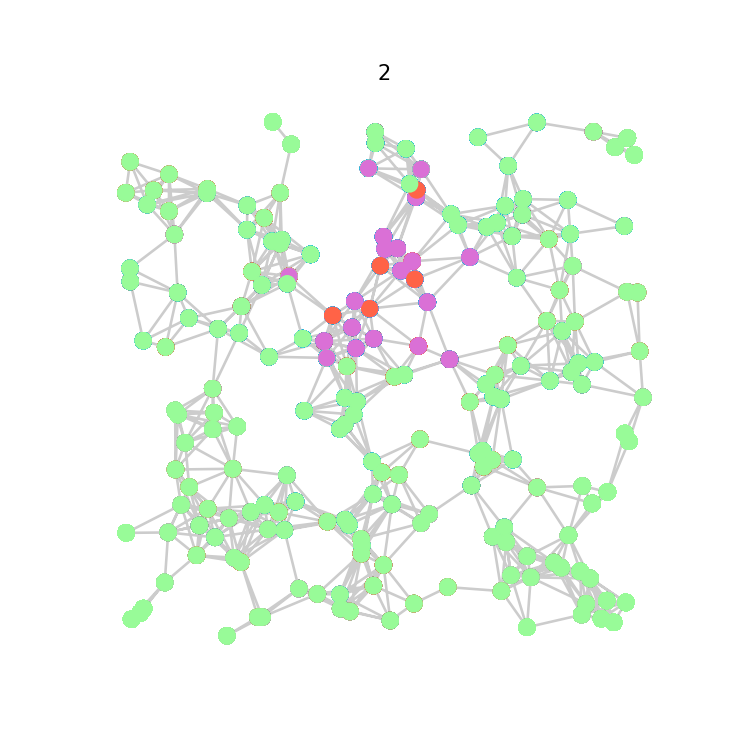

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


In [19]:
# Create animation
nodes = 200
exposedPerc = 0.1
radius = 0.12
beta = 0.4
delta = 0.1
gamma = 0.05
pictureWidth = 1
pictureHeight = 1
NTimeSteps = 50

interval = 400
plotStates= False

fig, ax = plt.subplots(figsize = [6*pictureWidth, 6*pictureHeight])
Network = start(nodes, radius, exposedPerc, pictureWidth, pictureHeight)
Network = everythingSEIR(Network, NTimeSteps, beta, delta, gamma, pictureWidth, pictureHeight, plotNetworks= False, plotStates= plotStates)
plotedges(Network['pos'], ax, Network['sets'], PL.edgeColor, PL.edgeAlpha)
def animate(i):
    ax.axis('off')
    plotnodes(Network['pos'], ax, PL.nodeSize, Network['dataColors'][i])
    ax.set_title(i)
aniSEIR = animation.FuncAnimation(fig, animate, frames= NTimeSteps + 1, repeat= True, interval= interval)
aniSEIR.save('aniSEIR.gif')
plt.show()

In [ ]:
# Average over N
nodes = 200
exposedPerc = 0.1
radius = 0.12
beta = 0.6
delta = 0.3
gamma = 0.1
pictureWidth = 1
pictureHeight = 1
NTimeSteps = 100

N = 100
plotAverage = True

averageS, averageE, averageI, averageR = averageSEIR(nodes, exposedPerc, radius, NTimeSteps, beta, delta, gamma, pictureWidth, pictureHeight, N, plotAverage)